In [1]:
# Step 1: Define constants

import numpy as np
from torch.nn import CrossEntropyLoss, NLLLoss

# Run specific
DATASET = "fashion-mnist" # "mnist", "fashion-mnist", "cifar"
RUN = "2"
ZERO_BASED_START_AT = 0
EPOCHS = 10
QUBITS = 4
SIMPLE_NEURONS_PER_FEATURE_PER_ROW = 8
LOSS_FUNC = NLLLoss()
PERTURB = True
NOISE_MODE = 'gaussian' # 'gaussian', 'salt', 'pepper', 's&p'
RESUME_TRAINING = True
CHOOSE_NEW_RECEPTIVE_FIELDS = False
CHOOSE_NEW_TRAINING_DATA = False
# Constants
QC_REPETITIONS = 1
CLASSES = 4
BATCH_SIZE = 256
FEATURE_BRIGHTNESS = 2
FEATURE_ANGLES = 2
FEATURE_FREQUENCIES = 1

#For dynamic kernels
KERNEL="dynamic"
MIN_KERNEL_SIZE = 5
MIN_KERNEL_SIZE_GABOR = 2

#Derived:
TOTAL_FEATURES_PER_SITE = FEATURE_BRIGHTNESS + FEATURE_ANGLES * FEATURE_FREQUENCIES * 2
TOTAL_FEATURES = SIMPLE_NEURONS_PER_FEATURE_PER_ROW * SIMPLE_NEURONS_PER_FEATURE_PER_ROW * TOTAL_FEATURES_PER_SITE

FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-q{QUBITS}-{QC_REPETITIONS}-c{CLASSES}-n{TOTAL_FEATURES}-k{KERNEL}'
COMMON_FILENAME_PREFIX = f'v3-{DATASET}-r{RUN}-n{TOTAL_FEATURES}-k{KERNEL}'

if DATASET == "cifar":
  IMAGE_WIDTH = 32
  TARGETS = np.array(["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"])  
elif DATASET == "fashion-mnist":
  IMAGE_WIDTH = 28
  TARGETS = np.array(["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]) 
else: 
  IMAGE_WIDTH = 28
  TARGETS = np.array([0,1,2,3,4,5,6,7,8,9])


## Settings
DEBUG = False
SAMPLE_RUN = False
SAMPLE_ITERATIONS = 10


In [2]:
# Step 2: Necessary imports

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from itertools import cycle
import random
import os.path as path
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.connectors import TorchConnector
from datetime import datetime

# Additional torch-related imports
import torch
from torch import Tensor, cat, no_grad, manual_seed
from torch.nn import Linear, MSELoss, Softmax
from torch.optim import LBFGS
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
from torch.nn import (
    Module,
    Conv2d,
    Linear,
    Bilinear,
    Dropout2d,
    MaxPool2d,
    Flatten,
    Sequential,
    ReLU,
)
import torch.nn.functional as F

# Project specific imports
from canonicallayers.brightnessextractor import extractBrightness, extractBrightnessAt
from canonicallayers.gaborfilterextractor import extract_power_feats
from canonicallayers.perturbations import skew, rotate, noise, elastic_transform
algorithm_globals.random_seed = 42

In [3]:
# Step 6 - Setup Feature Extraction parameters

gaborReceptiveFields = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborReceptiveFields.pt")
gaborKernels = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborKernels.pt")
gaborAngleTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborAngleTunings.pt")
gaborFrequencyTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborFrequencyTunings.pt")
gaborBrightnessTunings = torch.load(f"checkpoints/{COMMON_FILENAME_PREFIX}-gaborBrightnessTunings.pt")


In [4]:
# Step 3: Prepare Training data
# -------------

train_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-training.pt')
test_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-testing.pt')


In [5]:
# Step 8 - Feature extraction functions
dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1
gaborImgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1 # IMAGE_WIDTH - MIN_KERNEL_SIZE_GABOR +1


def extractFeatures(data, brightnessReceptiveFields, brightnessTunings, brightnessKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels):
  f = torch.zeros(data.shape[0],TOTAL_FEATURES_PER_SITE,SIMPLE_NEURONS_PER_FEATURE_PER_ROW,SIMPLE_NEURONS_PER_FEATURE_PER_ROW)
  # print("f", f.shape)
  #Fill Brigtness, orientation input
  for bi in range(0, data.shape[0]):
    for i in range(0, SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
      for j in range(0,SIMPLE_NEURONS_PER_FEATURE_PER_ROW):
        featureIndex = 0
        brightnessSpot = brightnessReceptiveFields[i][j]
        brightnessKernelSize = brightnessKernels[i][j]

        for br in range(0, FEATURE_BRIGHTNESS):
          brightnessTuning = brightnessTunings[br][i][j]
          b = extractBrightnessAt(data[bi].unsqueeze(0), brightnessTuning, brightnessSpot//imgWidth, brightnessSpot%imgWidth, brightnessKernelSize)
          f[bi][featureIndex][i][j] = b
          featureIndex += 1
        
        gaborSpot = gaborReceptiveFields[i][j].item()
        gaborKernelSize = gaborKernels[i][j].item()

        for an in range(0, FEATURE_ANGLES):
          for fr in range(0, FEATURE_FREQUENCIES):
            gaborFrequency = gaborFrequencyTunings[fr][i][j].item()
            gaborAngle = gaborAngleTunings[an][i][j].item()
            kernel, power_feats, power_img = extract_power_feats(data[bi].unsqueeze(0), gaborKernelSize, gaborSpot//gaborImgWidth, gaborSpot%gaborImgWidth, gaborFrequency, gaborAngle)
            f[bi][featureIndex][i][j] = power_feats[0]
            f[bi][featureIndex+1][i][j] = power_feats[1]
            featureIndex += 2
  return f

In [6]:
# Step 7- Define QNN Model

def parity(x):
    return x % CLASSES

# Define and create QNN
def create_qnn():
    feature_map = ZZFeatureMap(QUBITS, reps=QC_REPETITIONS)
    ansatz = RealAmplitudes(QUBITS, reps=1)
    qc = QuantumCircuit(QUBITS)
    qc.compose(feature_map, inplace=True)
    qc.compose(ansatz, inplace=True)

    # REMEMBER TO SET input_gradients=True FOR ENABLING HYBRID GRADIENT BACKPROP
    qnn = SamplerQNN(
        circuit=qc,
        input_params=feature_map.parameters,
        weight_params=ansatz.parameters,
        input_gradients=True,
        interpret=parity,
        output_shape=CLASSES
    )
    return qnn


qnn4 = create_qnn()

In [7]:
# Step 9 - Define torch NN module
class Net(Module):
    def __init__(self, qnn):
      super().__init__()
      self.fc1 = Linear(TOTAL_FEATURES, 32 * QUBITS)
      self.relu1 = ReLU()
      self.fc2 = Linear(32 * QUBITS, QUBITS)  # QUBIT-dimensional input to QNN
      self.relu2 = ReLU()
      self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen

    def forward(self, x):
      if(DEBUG):
        print("x shape", x.shape)
      x = extractFeatures(x, gaborReceptiveFields, gaborBrightnessTunings, gaborKernels, gaborReceptiveFields, gaborAngleTunings, gaborFrequencyTunings, gaborKernels)
      if(DEBUG):
        print("x features shape", x.shape)
      x = x.view(x.shape[0], -1)
      if(DEBUG):
        print("x after flat", x.shape)
        print("Total features", TOTAL_FEATURES, 32 * QUBITS)
      x = self.fc1(x)
      x = self.relu1(x)
      if(DEBUG):
        print("X after fc1", x.shape)
      x = self.fc2(x)
      x = self.relu2(x)
      if(DEBUG):
        print("x after fc2", x.shape)
      x = self.qnn(x)  # apply QNN
      if(DEBUG):
        print("After qnn, output", x.shape, x)
      return x




In [8]:
# Step 10 - Define torch NN module for Cifar

class CifarNet(Module):
    def __init__(self, qnn):
      super().__init__()
      self.conv1 = Conv2d(1, 32, kernel_size=3, padding=1)
      self.relu1 = ReLU()
      self.conv2 = Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
      self.mp2 = MaxPool2d(2, 2) # output: 64 x 16 x 16

      self.conv3 = Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
      self.relu3 = ReLU()
      self.conv4 = Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
      self.mp4 = MaxPool2d(2, 2) # output: 128 x 8 x 8

      self.conv5 = Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
      self.relu5 = ReLU()
      self.conv6 = Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
      self.mp6 = MaxPool2d(2, 2) # output: 256 x 4 x 4
      self.flatten = Flatten()
      self.fc1 = Linear(1024*4*4, 1024)
      self.relu7 = ReLU()
      self.fc2 = Linear(1024, 512)
      self.relu8 = ReLU()
      self.fc3 = Linear(512, QUBITS)
      self.qnn = TorchConnector(qnn)  # Apply torch connector, weights chosen

    def forward(self, x):
      if(DEBUG):
        print("x shape", x.shape)
      x = self.conv1(x)
      x = self.relu1(x)
      x = self.conv2(x)
      x = self.mp2(x)

      x = self.conv3(x)
      x = self.relu3(x)
      x = self.conv4(x)
      x = self.mp4(x)

      x = self.conv5(x)
      x = self.relu5(x)
      x = self.conv6(x)
      x = self.mp6(x)

      x = self.flatten(x)
      x = self.fc1(x)
      x = self.relu7(x)
      x = self.fc2(x)
      x = self.relu8(x)
      x = self.fc3(x)
      x = self.qnn(x)  # apply QNN
      return x


In [9]:
# Step 12 - Load previous results

loss_list = torch.load(f"checkpoints/{FILENAME_PREFIX}-losslist.pt")
  

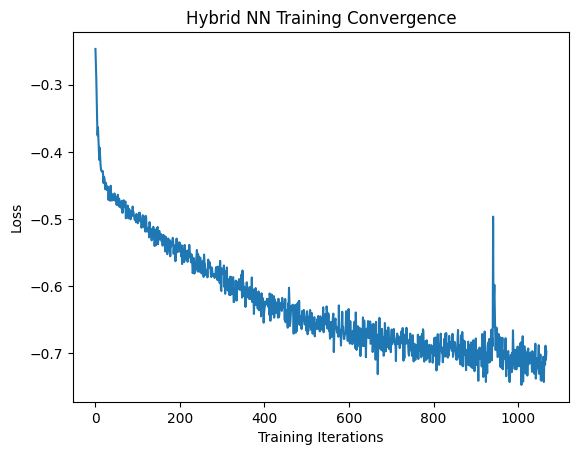

In [10]:
# Step 13 - Plot Prior Losses
plt.plot(loss_list)
plt.title("Hybrid NN Training Convergence")
plt.xlabel("Training Iterations")
plt.ylabel("Loss")
plt.show()

In [11]:

test_loader = torch.load(f'checkpoints/{COMMON_FILENAME_PREFIX}-testing.pt')


images shape torch.Size([256, 1, 28, 28])


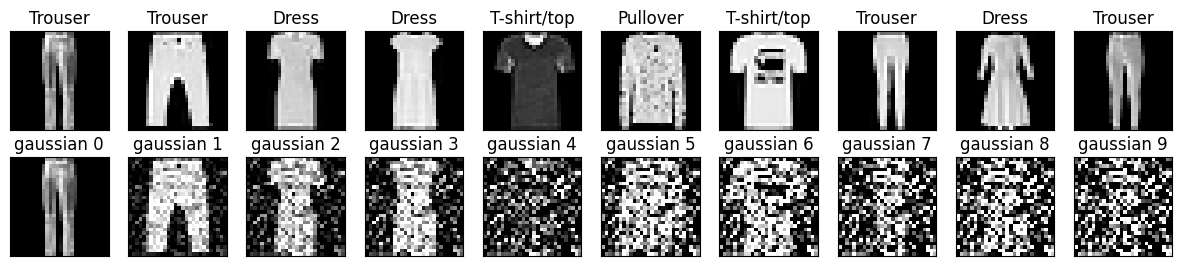

In [12]:
n_samples_show = 9

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=2, ncols=n_samples_show + 1, sharex=True, figsize=(15, 3))
images, targets = data_iter.__next__()
print("images shape", images.shape)

while n_samples_show >= 0:
    originalImage = images[n_samples_show,0]
    if(PERTURB and NOISE_MODE == 's&p'):
      perturbedImage = noise(originalImage.numpy(), mode=NOISE_MODE, amount=0.05*n_samples_show)
    elif(PERTURB and NOISE_MODE == 'gaussian'):
      if(n_samples_show == 0):
        perturbedImage = originalImage
      else:
        perturbedImage = noise(originalImage.numpy(), mode=NOISE_MODE)
        for n in range(n_samples_show):
          perturbedImage = noise(perturbedImage, mode=NOISE_MODE)

    perturbedData = torch.tensor(perturbedImage).unsqueeze(0).unsqueeze(0)

    axes[0,n_samples_show].imshow(originalImage.numpy().squeeze(), cmap="gray")
    axes[0,n_samples_show].set_xticks([])
    axes[0,n_samples_show].set_yticks([])
    axes[0,n_samples_show].set_title(TARGETS[targets[n_samples_show].item()])
    if(PERTURB):
      axes[1,n_samples_show].imshow(perturbedData[0].numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show].set_xticks([])
      axes[1,n_samples_show].set_yticks([])
      if(NOISE_MODE == 's&p'):
        axes[1,n_samples_show].set_title("{} {}%".format(NOISE_MODE, 0.05*100*n_samples_show))
      else:
        axes[1,n_samples_show].set_title("{} {}".format(NOISE_MODE, n_samples_show))
    else:
      axes[1,n_samples_show].imshow(originalImage.numpy().squeeze(), cmap="gray")
      axes[1,n_samples_show].set_xticks([])
      axes[1,n_samples_show].set_yticks([])
      axes[1,n_samples_show].set_title(TARGETS[targets[n_samples_show].item()])
      
    n_samples_show -= 1

In [13]:
# Step 18 - Predict
loss_func = LOSS_FUNC
epochs = EPOCHS  # Set number of epochs
start_at = ZERO_BASED_START_AT
epoch = 9
for noise_amount in range(EPOCHS):
  if(epoch < start_at):
    continue
  total_loss = []
  qnn = create_qnn()
  if DATASET == "blahblahblah":
    model = CifarNet(qnn4)
  else:
    model = Net(qnn4)
  if((path.isfile(f'checkpoints/{FILENAME_PREFIX}-modelweights-{epoch}.pt'))):
    model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights-{epoch}.pt'))
    model.eval()  # set model to evaluation mode
  else:
    print("End of epochs at", epoch, ", loading latest model")
    model.load_state_dict(torch.load(f'checkpoints/{FILENAME_PREFIX}-modelweights.pt'))
    model.eval()  # set model to evaluation mode
  with no_grad():
    dataWidth = SIMPLE_NEURONS_PER_FEATURE_PER_ROW
    imgWidth = IMAGE_WIDTH - MIN_KERNEL_SIZE +1

    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(test_loader):
      # if(batch_idx == 12):
      #   break

      if(PERTURB and NOISE_MODE == 's&p'):
        dataWithNoise = noise(data.numpy(), mode=NOISE_MODE, amount=0.05*n_samples_show)
      elif(PERTURB and NOISE_MODE == 'gaussian'):
        if(noise_amount == 0):
          dataWithNoise = data
        else:
          dataWithNoise = noise(data.numpy(), mode=NOISE_MODE)
          for n in range(noise_amount):
            dataWithNoise = noise(dataWithNoise, mode=NOISE_MODE)
      perturbedData = torch.tensor(dataWithNoise).type(torch.FloatTensor)


      output = model(perturbedData)
      # print("prediction output", output)
      print(total, end=" ")
      if len(output.shape) == 1:
          output = output.reshape(1, *output.shape)

      pred = output.argmax(dim=1, keepdim=True)
      total += pred.shape[0]
      correct += pred.eq(target.view_as(pred)).sum().item()

      loss = loss_func(output, target)
      total_loss.append(loss.item())

    if(PERTURB and NOISE_MODE == 's&p'):
      print("Noise: mode {} amount {}%", NOISE_MODE, noise_amount)
    elif(PERTURB and NOISE_MODE == 'gaussian'):
      print("Noise: mode {} pass {}", NOISE_MODE, noise_amount)

    print(
        "Performance on test data:\n\tLoss: {:.4f}\n\tDataset: {}, Classes: {}, Features: {}, Qubits: {}, Epoch: {} \n\tAccuracy: {:.1f}%".format(
            sum(total_loss) / len(total_loss), DATASET, CLASSES, TOTAL_FEATURES, QUBITS, epoch, correct * 100 / total
        )
    )

0 256 512 768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328 3584 3840 Noise: mode {} pass {} gaussian 0
Performance on test data:
	Loss: -0.6957
	Dataset: fashion-mnist, Classes: 4, Features: 384, Qubits: 4, Epoch: 9 
	Accuracy: 91.8%
0 256 512 768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328 3584 3840 Noise: mode {} pass {} gaussian 1
Performance on test data:
	Loss: -0.4693
	Dataset: fashion-mnist, Classes: 4, Features: 384, Qubits: 4, Epoch: 9 
	Accuracy: 62.8%
0 256 512 768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328 3584 3840 Noise: mode {} pass {} gaussian 2
Performance on test data:
	Loss: -0.4119
	Dataset: fashion-mnist, Classes: 4, Features: 384, Qubits: 4, Epoch: 9 
	Accuracy: 50.1%
0 256 512 768 1024 1280 1536 1792 2048 2304 2560 2816 3072 3328 3584 3840 Noise: mode {} pass {} gaussian 3
Performance on test data:
	Loss: -0.3675
	Dataset: fashion-mnist, Classes: 4, Features: 384, Qubits: 4, Epoch: 9 
	Accuracy: 46.1%
0 256 512 768 1024 1280 1536 1792 2048 2304 

In [14]:
import qiskit.tools.jupyter

%qiskit_version_table